# Passive liquidity on order books

Consider a pool consisting of **base asset** $\mathtt{A}$ of quantity $A$, and **quote asset** $\mathtt{B}$ of quantity $B$.

## Xyk pool

The pool follows the invariant:

$$
A \cdot B = K
$$

where $K$ is a constant.

### Pool price

We define the **pool price** $p_{\mathrm{pool}}$ as:

$$
p_{\mathrm{pool}} = - \frac{\mathrm{d} B}{\mathrm{d} A}
$$

- At prices $p > p_{\mathrm{pool}}$, the pool will place **ask** orders (sell base asset, buy quote asset).
- At prices $p < p_{\mathrm{pool}}$, the pool will place **bid** orders (sell quote asset, buy base asset).

For xyk pools,

$$
p_{\mathrm{pool}} = \frac{B}{A}
$$

### Bids

The pool placing a bid order means the pool wishes to increase its inventory of the base asset and decrease its inventory of the quote asset. This is equivalent to a trader performing a swap against the pool, inputting the base asset and outputting the quote asset.

Consider swapping quantity $a$ of the base asset into quantity $b$ of the quote asset:

$$
A \cdot B = (A + a) (B - b)
$$

Let's define the **price** of this swap as:

$$
p = \frac{b}{a}
$$

We can easily find:

$$
a = -A + \frac{B}{p}
$$

Consider another swap with a different input quantity $a'$ and price $p'$. We can similarly get:

$$
a' = -A + \frac{B}{p'}
$$

The difference in input amounts:

$$
\Delta a = a' - a = B \left( \frac{1}{p'} - \frac{1}{p} \right)
$$

Assume $p$ and $p'$ are two adjacent ticks and $p' < p < p_{\mathrm{pool}}$, this means **the pool will place a bid order of size $\Delta a$ at price $p'$**.

### Asks

Similarly, considering a trader swapping quantity $b$ of the quote asset into quantity $a$ of the base asset.

$$
A \cdot B = (A - a) (B + b)
$$

$$
p = \frac{b}{a}
$$

We find:

$$
a = A - \frac{B}{p}
$$

Consider another swap with output quantity $a'$ and price $p'$, we get:

$$
\Delta a = a' - a = B \left( \frac{1}{p} - \frac{1}{p'} \right)
$$

If $p$ and $p'$ are two adjacent ticks and $p' > p > p_{\mathrm{pool}}$, this means **the pool will place an ask order of size $\Delta a$ at price $p'$**. (Note: order sizes are always measured in the base asset, regardless of bid or ask.)

### Example

Consider a SOL-USD pool (SOL is the base asset; USD is the quote asset) containng 1 SOL and 200 USD, with \\$1 tick size. Pool price $p_{\mathrm{pool}} = \$200$. Let's compute the 20 orders the pool will place in the order book on each side of $p_{\mathrm{pool}}$:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Reserve of the base asset (SOL)
a = 1
# Reserve of the quote asset (USD)
b = 200
# Tick size
dp = 1
# Current pool price
p_pool = b / a

def compute_xyk_bids(num_ticks):
    # Start one tick below p_pool
    p = p_pool - dp
    ps = [p_pool]
    das = [0]

    for _ in range(num_ticks):
        da = b * dp / (p * (p + dp))
        ps.append(p)
        das.append(da)
        p -= dp

    return np.array(ps), np.array(das), np.cumsum(das)

def compute_xyk_asks(num_ticks):
    # Start one tick above p_pool
    p = p_pool + dp
    ps = [p_pool]
    das = [0]

    for _ in range(num_ticks):
        da = b * dp / (p * (p + dp))
        ps.append(p)
        das.append(da)
        p += dp

    return np.array(ps), np.array(das), np.cumsum(das)

In [3]:
def plot_result(compute_bids, compute_asks, num_ticks=30):
    bid_ps, bid_das, bid_depths = compute_bids(num_ticks)
    ask_ps, ask_das, ask_depths = compute_asks(num_ticks)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

    ax1.bar(bid_ps, bid_das, color="green")
    ax1.bar(ask_ps, ask_das, color="red")

    ax2.step(bid_ps, bid_depths, color="green")
    ax2.step(ask_ps, ask_depths, color="red")

    ax1.set_ylabel("Order Size (SOL)")
    ax2.set_ylabel("Order Depth (SOL)")
    ax2.set_xlabel("Price ($)")
    ax2.set_ylim(0)

    plt.tight_layout()
    plt.show()

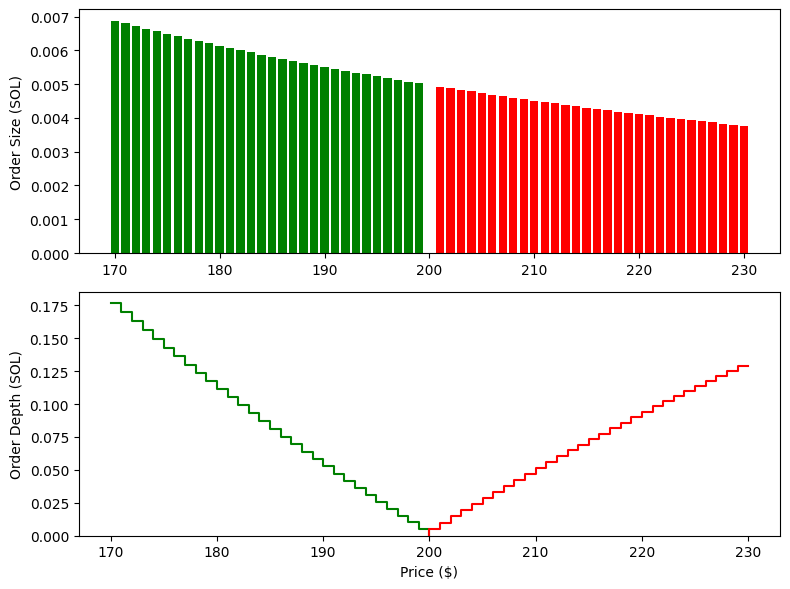

In [4]:
plot_result(compute_xyk_bids, compute_xyk_asks)

As the plot shows, at prices near $p_{\mathrm{pool}}$, liquidity is split roughly evenly across ticks. We prefer a different curve that concentrates liquidity around $p_{\mathrm{pool}}$.

## Solidly pool

The "naive" form of Solidly pool follows the invariant:

$$
A^3 B + A B^3 = K
$$

where $K$ is a constant.

This "naive" invariant assumes the two assets have the same price, which is of course not the case for our SOL-USD example. For such a case, assume we have an external oracle price of $R$ USD per SOL, the invariant can be modified as:

$$
A^3 \left( \frac{B}{R} \right) + A \left( \frac{B}{R} \right)^3 = K
$$

### Pool price

The formula for pool price is the same as before:

$$
p_{\mathrm{pool}} = - \frac{\mathrm{d} B}{\mathrm{d} A} = \frac{3 R^2 A^2 B + B^3}{R^2 A^3 + 3 A B^2}
$$

### Bids

Consider at price $p < p_{\mathrm{pool}}$, a trader swaps $a$ units of the base asset at price into $p \cdot a$ units of quote asset:

$$
K = A^3 \left( \frac{B}{R} \right) + A \left( \frac{B}{R} \right)^3
$$

$$
\alpha = A + a
$$

$$
\beta = \frac{B - pa}{R}
$$

$$
f(a) = \alpha^3 \beta + \alpha \beta^3 - K = 0
$$

This is a 4th-degree polynomial function, so finding an exactly solution is not feasible. Instead, we use **Newton's method**.

- choose an initial value $a_0 \ne 0$
- for $n = 1, 2, 3, \dots$ until converge:
  - $a_n \gets a_{n-1} - \frac{f(a_{n-1})}{f'(a_{n-1})}$

where

$$
f'(a) = - \frac{p}{R} \alpha^3 + 3 \alpha^2 \beta - \frac{3p}{R} \alpha \beta^2 + \beta^3
$$

### Asks

At the price $p > p_{\mathrm{pool}}$, same as above:

$$
\alpha = A - a
$$

$$
\beta = \frac{B + pa}{R}
$$

$$
f(a) = \alpha^3 \beta + \alpha \beta^3 - K
$$

$$
f'(a) = \frac{p}{R} \alpha^3 - 3 \alpha^2 \beta + \frac{3p}{R} \alpha \beta^2 - \beta^3
$$

In [27]:
# Reserve of the base asset (SOL)
a = 1
# Reserve of the quote asset (USD)
b = 200
# Tick size
dp = 0.5

# Current oracle price
# Note: try changing this value to slightly above or below 200
r = 200

# Current pool price
p_pool = (3 * r * r * a * a * b + b * b * b) / (r * r * a * a * a + 3 * a * b * b)

# The current invariant value
k = a * a * a * b / r + a * b * b * b / r / r / r

# Note: The math here is very unoptimized.
# Code here is for illustrative purpose, not for production,
# so we choose to stick close to the original math formulae.
def compute_solidly_bid_a(p, tolerance=1e-6, max_iterations=32):
    # Initial value is really important here.
    # A bad initial value can result in getting the trivial solution (zero).
    old = 0.5
    for _ in range(max_iterations):
        alpha = a + old
        beta = (b - p * old) / r
        f = alpha * alpha * alpha * beta + alpha * beta * beta * beta - k
        f_prime = - p * alpha * alpha * alpha / r + 3 * alpha * alpha * beta - 3 * p * alpha * beta * beta / r + beta * beta * beta
        new = old - f / f_prime
        if abs(new - old) <= tolerance:
            return new
        else:
            old = new
    raise Exception("failed to converge within max iterations")

def compute_solidly_bids(num_ticks):
    p = p_pool - dp
    ps = [p_pool]
    das = [0]
    last_a = 0

    for _ in range(num_ticks):
        a = compute_solidly_bid_a(p)
        da = a - last_a
        ps.append(p)
        das.append(da)
        p -= dp
        last_a = a

    return np.array(ps), np.array(das), np.cumsum(das)

def compute_solidly_ask_a(p, tolerance=1e-6, max_iterations=32):
    old = 0.5
    for _ in range(max_iterations):
        alpha = a - old
        beta = (b + p * old) / r
        f = alpha * alpha * alpha * beta + alpha * beta * beta * beta - k
        f_prime = p * alpha * alpha * alpha / r - 3 * alpha * alpha * beta + 3 * p * alpha * beta * beta / r - beta * beta * beta
        new = old - f / f_prime
        if abs(new - old) <= tolerance:
            return new
        else:
            old = new
    raise Exception("failed to converge within max iterations")

def compute_solidly_asks(num_ticks):
    p = p_pool + dp
    ps = [p_pool]
    das = [0]
    last_a = 0

    for _ in range(num_ticks):
        a = compute_solidly_ask_a(p)
        da = a - last_a
        ps.append(p)
        das.append(da)
        p += dp
        last_a = a

    return np.array(ps), np.array(das), np.cumsum(das)

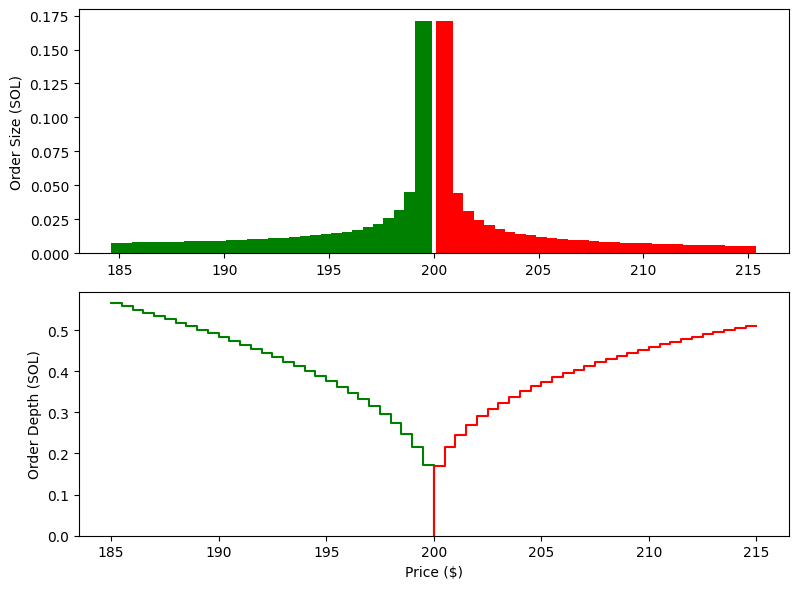

In [28]:
plot_result(compute_solidly_bids, compute_solidly_asks)

As we see, liquidity is indeed a lot more concentrated here.

The main problem with this pool type is that Newton's method often finds the trivial solution ($a = 0$) instead of the non-zero solution we're looking for. The choice of the initial value seems to be vital.